<a href="https://colab.research.google.com/github/AbeerAbuZayed/QUIUG_Hate-Speech-Detection_OSACT4-Workshop/blob/master/%5BPart_2%5DHate-Speech-Detection_Neural-Learning-Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#[Part 2] Hate speech Detection using Neural Learning Models
In this notebook, we conduct a preliminary experiment on the detection of hate speech in Arabic tweets as part of our participation in the Hate Speech Detection subtask in [OSACT4 workshop](http://edinburghnlp.inf.ed.ac.uk/workshops/OSACT4/).

We experimented with three types of neural models:
### 1.   Recurrent Neural Networks (RNN):
>*   Long Short-Term Memory (LSTM)
>*   Bidirectional LSTM (BLSTM)
>*   Gated Recurrent Unit (GRU)


### 2.   Convolutional Neural Networks (CNN)

### 3.   Combined CNN-RNN:
>* CNN-LSTM
>* CNN-BLSTM
>* CNN-GRU
>* CNN-LSTM with overSampling




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
from keras.layers import Embedding, Dense, Dropout, Input, LSTM, Bidirectional,GRU
from keras.layers import MaxPooling1D, Conv1D, Flatten
from keras.preprocessing import sequence, text
from keras.models import Model
from keras.utils import np_utils
from keras.callbacks import Callback

from gensim.models.keyedvectors import KeyedVectors
from sklearn import preprocessing
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

from keras import optimizers

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from sklearn.utils import class_weight

from sklearn import preprocessing
from sklearn.metrics import (
    classification_report as creport
)


Using TensorFlow backend.


# Data and AraVec2.0 (pre-trained word embeddings model) Loading

In [3]:
#pre-trained word embedding: https://github.com/bakrianoo/aravec/tree/master/AraVec%202.0
"""
Citation:
Abu Bakr Soliman, Kareem Eisa, and Samhaa R. El-Beltagy, “AraVec:
A set of Arabic Word Embedding Models for use in Arabic NLP”,
in proceedings of the 3rd International Conference on 
Arabic Computational Linguistics (ACLing 2017), Dubai, UAE, 2017.
"""
! unzip '/content/drive/My Drive/New- test/tweets_sg_300.zip'  

Archive:  /content/drive/My Drive/New- test/tweets_sg_300.zip
  inflating: tweets_sg_300           
  inflating: tweets_sg_300.trainables.syn1neg.npy  
  inflating: tweets_sg_300.wv.vectors.npy  


In [0]:
# Word_embedding_path
embedding_path = '/content/tweets_sg_300'           #Twitter-Skipgram model-300d(trained on 77,600,000 Arabic tweets)

In [3]:
train_data = pd.read_csv('/content/drive/My Drive/OSACT4/train_data.csv')
train_data

,Tweet,Offensive,Hate
0,الحمدلله يارب فوز مهم يا زمالك.. كل الدعم ليكم...,NOT_OFF,NOT_HS
1,فدوه يا بخت فدوه يا زمن واحد منكم يجيبه,NOT_OFF,NOT_HS
2,RT @USER: يا رب يا واحد يا أحد بحق يوم الاحد ا...,OFF,HS
3,RT @USER: #هوا_الحرية يا وجع قلبي عليكي يا امي...,NOT_OFF,NOT_HS
4,يا بكون بحياتك الأهم يا إما ما بدي أكون 🎼,NOT_OFF,NOT_HS
...,...,...,...
6995,@USER يا حمار ، يا جاهل ، نسبة الباطل ما بتتحس...,OFF,NOT_HS
6996,RT @USER: @USER كل زق يا طاقية يا واطي يا حقير...,OFF,NOT_HS
6997,@USER<LF>يا كبير يا ممتع يا نجم لابد أن تعي جي...,NOT_OFF,NOT_HS
6998,يا رب الاتحاد يفوز يا رب. 😭😭 #الاتحاد_النصر,NOT_OFF,NOT_HS


In [4]:
dev_data = pd.read_csv('/content/drive/My Drive/OSACT4/dev_data.csv')
dev_data

,Tweet,Offensive,Hate
0,فى حاجات مينفعش نلفت نظركوا ليها زى الاصول كده...,NOT_OFF,NOT_HS
1,RT @USER: وعيون تنادينا تحايل فينا و نقول يا ع...,NOT_OFF,NOT_HS
2,يا بلادي يا أم البلاد يا بلادي بحبك يا مصر بحب...,NOT_OFF,NOT_HS
3,RT @USER: يا رب يا قوي يا معين مدّني بالقوة و ...,NOT_OFF,NOT_HS
4,RT @USER: رحمك الله يا صدام يا بطل ومقدام. URL,NOT_OFF,NOT_HS
...,...,...,...
995,RT @USER: انتو بتوزعوا زيت وسكر فعلا يا عباس؟<...,NOT_OFF,NOT_HS
996,RT @USER: كدا يا عمر متزعلهاش يا حبيبي 😂 URL,NOT_OFF,NOT_HS
997,هدا سكن اطفال امارتين من شارقة طالبين فزعتكم ي...,NOT_OFF,NOT_HS
998,RT @USER: ومدني بمدد من قوتك أواجه به ضعفي.. و...,NOT_OFF,NOT_HS


In [5]:
print("Train data shape: {} \nDev data shape: {}".format(train_data.shape,dev_data.shape))


Train data shape: (7000, 3) 
Dev data shape: (1000, 3)


In [0]:
def get_embedding_matrix(word_index, embedding_index, vocab_dim):
    print('Building embedding matrix...')
    embedding_matrix = np.zeros((len(word_index) + 1, vocab_dim))
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index.get_vector(word)
        except:
            pass
    print('Embedding matrix built.') 
    #print("Word index", word_index.items())
    #print(embedding_matrix) 
    return embedding_matrix


def get_init_parameters(path, ext=None):
    if ext == 'vec':
        word_model = KeyedVectors.load_word2vec_format(path).wv
    else:
        word_model = KeyedVectors.load(path).wv
    n_words = len(word_model.vocab)
    vocab_dim = word_model[word_model.index2word[0]].shape[0]
    index_dict = dict()
    for i in range(n_words):
        index_dict[word_model.index2word[i]] = i+1
    print('Number of words in the word embedding',n_words)
    #print('word_model', word_model)
    #print("index_dict",index_dict)
    return word_model, index_dict, n_words, vocab_dim

def get_max_length(text_data, return_line=False):
    max_length = 0
    long_line = ""
    for line in text_data:
        new = len(line.split())
        if new > max_length:
            max_length = new
            long_line = line
    if return_line:
        return long_line, max_length
    else:
        return max_length
    print("max",long_line,max_length)

def load_datasets(data_paths, header=True):
    x = []
    y = []
    for data_path in data_paths:
        with open(data_path, 'r') as f:
            for line in f:
                if header:
                    header = False
                else:
                    temp = line.split(',')
                    x.append(temp[0])
                    y.append(temp[2].replace('\n', ''))
    max_length = get_max_length(x)
    print('Max length:', max_length)
    return x,y, max_length

def get_train_test(train_raw_text, test_raw_text, n_words, max_length):
    tokenizer = text.Tokenizer(num_words=n_words)
    tokenizer.fit_on_texts(list(train_raw_text))
    word_index = tokenizer.word_index
   
    train_tokenized = tokenizer.texts_to_sequences(train_raw_text)
    test_tokenized = tokenizer.texts_to_sequences(test_raw_text)

    return sequence.pad_sequences(train_tokenized, maxlen=max_length, padding='post', truncating='post'),\
           sequence.pad_sequences(test_tokenized, maxlen=max_length, padding='post', truncating='post'),\
           word_index

def class_str_2_ind(x_train, x_test, y_train, y_test, classes, n_words, max_length):
    print('Converting data to trainable form...')
    y_encoder = preprocessing.LabelEncoder()
    y_encoder.fit(classes)
    y_train = y_encoder.transform(y_train)
    y_test = y_encoder.transform(y_test)
    #print(y_train)
    #print(y_test)
    train_y_cat = np_utils.to_categorical(y_train, len(classes))
    x_vec_train, x_vec_test, word_index = get_train_test(x_train, x_test, n_words, max_length)
    print('Number of training examples: ' + str(len(x_vec_train)))
    print('Number of dev examples: ' + str(len(x_vec_test)))
    return x_vec_train, x_vec_test, y_train, y_test, train_y_cat, word_index


In [7]:
WORD_MODEL, _, MAX_FEATURES, EMBED_SIZE = get_init_parameters(embedding_path) 

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Number of words in the word embedding 331679


In [8]:
# load train data
train_data_path=["/content/drive/My Drive/OSACT4/train_data_cleaned.csv"]
x_train, y_train, MAX_TEXT_LENGTH = load_datasets(train_data_path)
CLASSES_LIST = np.unique(y_train)
print('Label categories: ' + str(CLASSES_LIST))
#0= HS, 1= NOT_HS

Max length: 84
Label categories: ['HS' 'NOT_HS']


In [9]:
# load dev data
dev_data_path=["/content/drive/My Drive/OSACT4/dev_data_cleaned.csv"]
x_dev, y_dev, MAX_TEXT_LENGTH = load_datasets(dev_data_path)
CLASSES_LIST = np.unique(y_dev)
print('Label categories: ' + str(CLASSES_LIST))
#0= HS, 1= NOT_HS

Max length: 72
Label categories: ['HS' 'NOT_HS']


In [0]:
MAX_TEXT_LENGTH=84

In [11]:
x_train, x_dev, y_train, y_dev, train_y_cat, word_index = class_str_2_ind(x_train, x_dev, 
                                                                            y_train, y_dev,
                                                                            CLASSES_LIST, MAX_FEATURES,
                                                                            MAX_TEXT_LENGTH)
dev_cat_y = np_utils.to_categorical(y_dev, len(CLASSES_LIST))

Converting data to trainable form...
Number of training examples: 7000
Number of dev examples: 1000


In [12]:
print("Tokens number: "+str(len(word_index)))

Tokens number: 30125


In [13]:
# Sequence length
print("Original sequence length: "+str(MAX_TEXT_LENGTH))


Original sequence length: 84


In [0]:
def get_model(embedding_weights, word_index, vocab_dim, max_length,layer, dropout, optimizer, print_summary=True):
    """
    Create Neural Network With an Embedding layer
    """
    inp = Input(shape=(max_length,))
    model = Embedding(input_dim=len(word_index)+1,
                      output_dim=vocab_dim,
                      trainable=False,
                      weights=[embedding_weights])(inp)
    model = layer(model)
    model = Dropout(dropout)(model)       
    model = Flatten()(model)
    model = Dense(2, activation='sigmoid')(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    if print_summary:
        model.summary()
    return model


def get_main_model(word_index, WORD_MODEL, EMBED_SIZE, MAX_TEXT_LENGTH, 
                   layer, dropout,optimizer):
   
    tmp = get_embedding_matrix(word_index, WORD_MODEL, EMBED_SIZE)
    model = get_model(tmp, word_index, EMBED_SIZE, MAX_TEXT_LENGTH, 
                      layer, dropout, optimizer= optimizer ,print_summary=True)
    return model


class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

def train_fit_predict(model, x_train, x_test, y_train, y_test,class_weight, batch_size, epochs, TestCallback=TestCallback):
   
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs, verbose=1,
                        validation_data=(x_test, y_test),
                        class_weight=class_weight,
                        callbacks=[TestCallback((x_test, y_test))])
    return history, model

#### Note: the prior work is the same for all of the neural learning models.

#  RNN (LSTM) Model

In [42]:
model = get_main_model(word_index, WORD_MODEL, EMBED_SIZE, MAX_TEXT_LENGTH, 
                       layer= LSTM(units=16, return_sequences=True, return_state=False), dropout=0.5, 
                       optimizer= optimizers.Adam(0.001))

Building embedding matrix...
Embedding matrix built.
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 84)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 84, 300)           9037800   
_________________________________________________________________
lstm_4 (LSTM)                (None, 84, 16)            20288     
_________________________________________________________________
dropout_4 (Dropout)          (None, 84, 16)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1344)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2690      
Total params: 9,060,778
Trainable params: 22,978
Non-trainable params: 9

In [43]:
time_start = time()
history, model = train_fit_predict(model,
                               x_train[:, :MAX_TEXT_LENGTH],
                               x_dev[:, :MAX_TEXT_LENGTH],
                               train_y_cat, dev_cat_y, class_weight=None,
                               batch_size=500, epochs=15)
time_start = time() - time_start

print("Took : "+str(np.round(time_start, 2))+" (s)") 

Train on 7000 samples, validate on 1000 samples
Epoch 1/15
7000/7000 [==============================] - 6s 835us/step - loss: 0.5457 - acc: 0.8749 - val_loss: 0.3351 - val_acc: 0.9560

Testing loss: 0.3351476159095764, acc: 0.956

Epoch 2/15
7000/7000 [==============================] - 5s 667us/step - loss: 0.2695 - acc: 0.9484 - val_loss: 0.2055 - val_acc: 0.9560

Testing loss: 0.20551465719938278, acc: 0.956

Epoch 3/15
7000/7000 [==============================] - 5s 673us/step - loss: 0.2125 - acc: 0.9484 - val_loss: 0.1784 - val_acc: 0.9560

Testing loss: 0.1783983495235443, acc: 0.956

Epoch 4/15
7000/7000 [==============================] - 5s 668us/step - loss: 0.1873 - acc: 0.9484 - val_loss: 0.1642 - val_acc: 0.9560

Testing loss: 0.16415698558092118, acc: 0.956

Epoch 5/15
7000/7000 [==============================] - 5s 674us/step - loss: 0.1735 - acc: 0.9484 - val_loss: 0.1513 - val_acc: 0.9560

Testing loss: 0.15130487981438637, acc: 0.956

Epoch 6/15
7000/7000 [============

In [44]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [45]:
model.evaluate(x_dev[:, :MAX_TEXT_LENGTH], dev_cat_y, batch_size=1000)


1000/1000 [==============================] - 0s 306us/step


[0.11841938644647598, 0.9589999914169312]

In [46]:
y_pred = np.argmax(model.predict(x_dev[:, :MAX_TEXT_LENGTH]), axis=1)

print(creport(np.argmax(dev_cat_y, axis=1), y_pred,target_names=['HS', 'NOT_HS'],digits=4))

              precision    recall  f1-score   support

          HS     0.5882    0.2273    0.3279        44
      NOT_HS     0.9654    0.9927    0.9789       956

    accuracy                         0.9590      1000
   macro avg     0.7768    0.6100    0.6534      1000
weighted avg     0.9488    0.9590    0.9502      1000



In [49]:
n = np.argmin(history.history['val_loss'])

print("Optimal epoch : {}".format(n))
print("Accuracy on train : {} %".format(np.round(history.history['acc'][n]*100, 2)))
print("Accuracy on val : {} %".format(np.round(history.history['val_acc'][n]*100, 2)))
print("Loss on train : {}".format(np.round(history.history['loss'][n]*100, 2)))
print("Loss on Val : {}".format(np.round(history.history['val_loss'][n]*100, 2)))

Optimal epoch : 14
Accuracy on train : 95.97 %
Accuracy on val : 95.9 %
Loss on train : 9.86
Loss on Val : 11.84


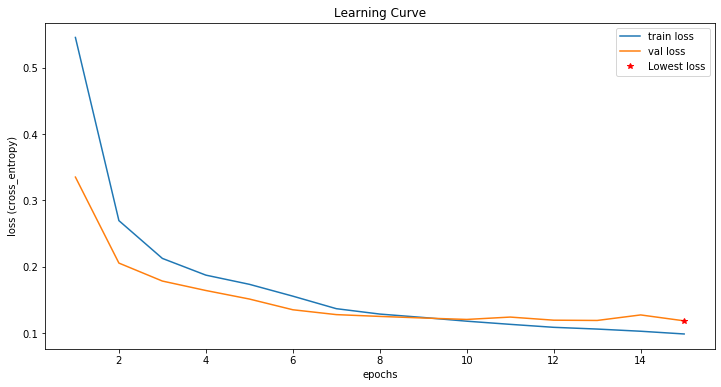

In [50]:
plt.figure("Loss Plot", figsize=(12, 6))
plt.plot(range(1, len(history.history['loss'])+1), history.history['loss'], label="train loss")
plt.plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'], label="val loss")
plt.plot(n+1,history.history["val_loss"][n],"r*", label="Lowest loss")
plt.legend()
plt.title("Learning Curve")
plt.ylabel("loss (cross_entropy)")
plt.xlabel("epochs")
plt.show();

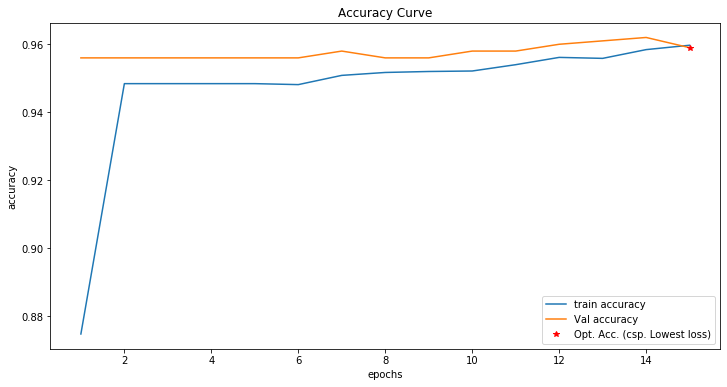

In [51]:
plt.figure("Accuracy Plot", figsize=(12, 6))
plt.plot(range(1, len(history.history['acc'])+1), history.history['acc'], label="train accuracy")
plt.plot(range(1, len(history.history['val_acc'])+1), history.history['val_acc'], label="Val accuracy")
plt.plot(n+1,history.history["val_acc"][n],"r*", label="Opt. Acc. (csp. Lowest loss)")
plt.legend()
plt.title("Accuracy Curve")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.show()

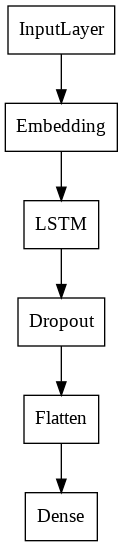

In [52]:
from keras.utils import plot_model
plot_model(model, to_file='RNN_LSTM_model.png', show_shapes=False, show_layer_names=False)

# RNN (BLSTM) Model 


In [167]:
model = get_main_model(word_index, WORD_MODEL, EMBED_SIZE, MAX_TEXT_LENGTH, 
                       layer= Bidirectional(LSTM(units=32, return_sequences=True, return_state=False)), 
                       dropout=0.2, optimizer=optimizers.Adam())

Building embedding matrix...
Embedding matrix built.
Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 84)                0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 84, 300)           9037800   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 84, 64)            85248     
_________________________________________________________________
dropout_16 (Dropout)         (None, 84, 64)            0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 5376)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 10754     
Total params: 9,133,802
Trainable params: 96,002
Non-trainable params: 

In [168]:
time_start = time()
history, model = train_fit_predict(model,
                               x_train[:, :MAX_TEXT_LENGTH],
                               x_dev[:, :MAX_TEXT_LENGTH],
                               train_y_cat, dev_cat_y, class_weight=None,
                               batch_size=500, epochs=10)
time_start = time() - time_start

print("Took : "+str(np.round(time_start, 2))+" (s)") 

Train on 7000 samples, validate on 1000 samples
Epoch 1/10
7000/7000 [==============================] - 17s 2ms/step - loss: 0.4376 - acc: 0.9081 - val_loss: 0.2274 - val_acc: 0.9560

Testing loss: 0.2274200958609581, acc: 0.956

Epoch 2/10
7000/7000 [==============================] - 13s 2ms/step - loss: 0.2185 - acc: 0.9484 - val_loss: 0.1814 - val_acc: 0.9560

Testing loss: 0.18138790315389633, acc: 0.956

Epoch 3/10
7000/7000 [==============================] - 13s 2ms/step - loss: 0.1825 - acc: 0.9484 - val_loss: 0.1589 - val_acc: 0.9560

Testing loss: 0.15891621419787408, acc: 0.956

Epoch 4/10
7000/7000 [==============================] - 13s 2ms/step - loss: 0.1575 - acc: 0.9489 - val_loss: 0.1405 - val_acc: 0.9560

Testing loss: 0.1404514151662588, acc: 0.956

Epoch 5/10
7000/7000 [==============================] - 13s 2ms/step - loss: 0.1369 - acc: 0.9513 - val_loss: 0.1263 - val_acc: 0.9590

Testing loss: 0.12626913669705392, acc: 0.959

Epoch 6/10
7000/7000 [=================

In [169]:
model.evaluate(x_dev[:, :MAX_TEXT_LENGTH], dev_cat_y, batch_size=1000)

1000/1000 [==============================] - 1s 546us/step


[0.1215435266494751, 0.9559999704360962]

In [170]:
y_pred = np.argmax(model.predict(x_dev[:, :MAX_TEXT_LENGTH]), axis=1)

print(creport(np.argmax(dev_cat_y, axis=1), y_pred,target_names=['HS', 'NOT_HS'],digits=4))

              precision    recall  f1-score   support

          HS     0.5000    0.2727    0.3529        44
      NOT_HS     0.9672    0.9874    0.9772       956

    accuracy                         0.9560      1000
   macro avg     0.7336    0.6301    0.6651      1000
weighted avg     0.9467    0.9560    0.9498      1000



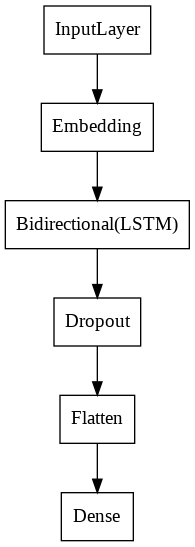

In [173]:
plot_model(model, to_file='RNN_BLSTM_model.png', show_shapes=False, show_layer_names=False)

# RNN (GRU) Model


In [181]:
model = get_main_model(word_index, WORD_MODEL, EMBED_SIZE, MAX_TEXT_LENGTH, 
                       layer= GRU(units=16, return_sequences=True, return_state=False), 
                       dropout=0.5, optimizer=optimizers.Adam())

Building embedding matrix...
Embedding matrix built.
Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 84)                0         
_________________________________________________________________
embedding_18 (Embedding)     (None, 84, 300)           9037800   
_________________________________________________________________
gru_4 (GRU)                  (None, 84, 16)            15216     
_________________________________________________________________
dropout_18 (Dropout)         (None, 84, 16)            0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 1344)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 2690      
Total params: 9,055,706
Trainable params: 17,906
Non-trainable params: 

In [182]:
time_start = time()
history, model = train_fit_predict(model,
                               x_train[:, :MAX_TEXT_LENGTH],
                               x_dev[:, :MAX_TEXT_LENGTH],
                               train_y_cat, dev_cat_y, class_weight=None,
                               batch_size=500, epochs=15)
time_start = time() - time_start

print("Took : "+str(np.round(time_start, 2))+" (s)") 

Train on 7000 samples, validate on 1000 samples
Epoch 1/15
7000/7000 [==============================] - 8s 1ms/step - loss: 0.5246 - acc: 0.8624 - val_loss: 0.3077 - val_acc: 0.9560

Testing loss: 0.3077390531301498, acc: 0.956

Epoch 2/15
7000/7000 [==============================] - 4s 540us/step - loss: 0.2563 - acc: 0.9484 - val_loss: 0.2055 - val_acc: 0.9560

Testing loss: 0.20550610518455506, acc: 0.956

Epoch 3/15
7000/7000 [==============================] - 4s 536us/step - loss: 0.2139 - acc: 0.9484 - val_loss: 0.1780 - val_acc: 0.9560

Testing loss: 0.17800627326965332, acc: 0.956

Epoch 4/15
7000/7000 [==============================] - 4s 538us/step - loss: 0.1917 - acc: 0.9484 - val_loss: 0.1686 - val_acc: 0.9560

Testing loss: 0.16861123284697532, acc: 0.956

Epoch 5/15
7000/7000 [==============================] - 4s 536us/step - loss: 0.1811 - acc: 0.9484 - val_loss: 0.1600 - val_acc: 0.9560

Testing loss: 0.16001157158613205, acc: 0.956

Epoch 6/15
7000/7000 [=============

In [183]:
model.evaluate(x_dev[:, :MAX_TEXT_LENGTH], dev_cat_y, batch_size=1000)

1000/1000 [==============================] - 0s 229us/step


[0.1155305728316307, 0.9570000171661377]

In [184]:
y_pred = np.argmax(model.predict(x_dev[:, :MAX_TEXT_LENGTH]), axis=1)

print(creport(np.argmax(dev_cat_y, axis=1), y_pred,target_names=['HS', 'NOT_HS'],digits=4))

              precision    recall  f1-score   support

          HS     0.5263    0.2273    0.3175        44
      NOT_HS     0.9653    0.9906    0.9778       956

    accuracy                         0.9570      1000
   macro avg     0.7458    0.6089    0.6476      1000
weighted avg     0.9460    0.9570    0.9487      1000



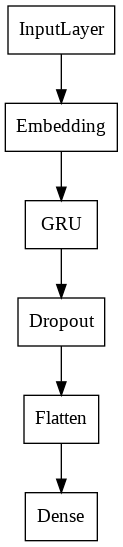

In [180]:
plot_model(model, to_file='RNN_GRU_model.png', show_shapes=False, show_layer_names=False)

# CNN Model
[Colab Notebook](https://colab.research.google.com/drive/1_USllONVZIbf88aoPuQrzg9sg5HtY7K7)

# Combined CNN-RNN Models
[Colab Notebook](https://colab.research.google.com/drive/1LbZdJNvTzTqu6qLjDbOaeccJl36anJEw)